In [3]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import colorsys
import matplotlib.colors as mc
import matplotlib.pyplot as plt
from matplotlib import pylab
import seaborn as sns
import common.plots as plo
import cPickle as pkl
from textwrap import wrap

In [4]:
with open("../regression/color_dict_pt.pkl", "rb") as f: 
    color_dict_pt = pkl.load(f)
with open("../regression/color_dict_bar.pkl", "rb") as f: 
    color_dict_bar = pkl.load(f)

In [5]:
expt_legend_lookup = {
"NEG_RM": "Negatives Removed",
"NEG_UW" : "Negatives Upweighted",
"STD": "STD",
"NEG_RM_SMA": "Negatives Removed +SNA",
"STD_SMA": "SNA",
"scrambled_idx_LC": "SNA scrambled",
"SEA_SMA": "SNA +SEA blacklist",
"scrambled_idx_no_SMA_LC": "STD scrambled",
"CLASSIFIER_SEA_SMA": "SNA +SEA blacklist (classifier)",
"CLASSIFIER_NEG_RM_SMA_RATIOS":  "Negatives Removed +SNA (classifier)",
"CLASSIFIER_SMA_RATIOS": "SNA (classifier)",
"CLASSIFIER_scrambled_idx_LC": "SNA scrambled (classifier)",
"CLASSIFIER_scrambled_idx_No_SMA_LC": "STD scrambled (classifier)",
"CLASSIFIER_STD": "STD (classifier)", 
"NEG_RM_scrambled": "Negatives Removed scrambled", 
"NEG_RM_RATIOS_scrambled": "Negatives Removed +SNA scrambled",
'CLASSIFIER_NEG_RM_scrambled' : "Negatives Removed scrambled (classifier)",
'CLASSIFIER_NEG_RM_RATIOS_scrambled': "Negatives Removed +SNA scrambled (classifier)",
'CLASSIFIER_NEG_RM': 'Negatives Removed (classifier)', 
'CLASSIFIER_SEA_SMA': 'SNA +SEA blacklist (classifier)'}

In [6]:
# data handling

def get_env_var(handle):
    ''' Get an environment variable given the handle for the bash variable'''
    tmp = os.getenv(handle)
    if not tmp:
        raise LookupError("Environment variable: {} not set.".format(handle))
    return tmp.strip("'")

def get_preds(dset_dict, expt, dset, fold, ratio=None):
    indir = data_dict[expt]["indir"]
    if ratio is not None:
        knowns_file = data_dict[expt]["knowns_fmt"].format(indir, ratio, dset, fold)
        preds_file = data_dict[expt]["preds_fmt"].format(indir, ratio, dset, fold)
    else:
        knowns_file = data_dict[expt]["knowns_fmt"].format(indir, dset, fold)
        preds_file = data_dict[expt]["preds_fmt"].format(indir, dset, fold)
        
    prediction = np.load(preds_file)
    truth = np.load(knowns_file)
    
    if dset_dict[expt]["npz_fmt"] == True:
        prediction = prediction["arr_0"]
        truth = truth["arr_0"]
    return prediction, truth

In [7]:
home_dir = get_env_var("HOME_SAVE_BASE")

In [8]:
cl_data_file = "./classification_preds_file_lookup.pkl"
with open(cl_data_file, "rb") as f:
    data_dict = pkl.load(f)

In [9]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    
    Credit: Ian Hincks from https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
    """
    try:
        c = mc.cnames[color]
    except:
        c = color

    c = colorsys.rgb_to_hls(*mc.colorConverter.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


In [31]:
def plot_k_folds(dset_dict, expt, dset, ax, plot_rand=False, threshold=6.0, ratio=None, x_y_type='tpr-fpr', 
                 color="red", amount=0.4, classification=True):
    first = True
    
    for fold in np.arange(0,5,1):
        
        prediction, truth = get_preds(dset_dict, expt, dset, fold, ratio=ratio)
        
        if dset != "drugmatrix":
            known_mask = ~np.isnan(truth)
            truth = truth[known_mask]
            prediction = prediction[known_mask]
            
        # no need to ravel/flatten beforehand. this function does it.    
        auc = plo.plot_binary_auc(prediction, truth, threshold=threshold, plot_rand=False, ax=ax, 
                                  x_y_type='tpr-fpr', show_legend=False, classification=classification,
                                  **{"color":lighten_color(color, amount=amount)})
        if first:
            preds = prediction
            truths = truth
            first = False
            
        else: 
            preds = np.hstack([preds, prediction])
            truths = np.hstack([truths, truth])

    return preds, truths

def plot_roc_comp(dset_dict, expt_list, dset, save_name=None, thresh=6.0, ratio=None, 
                  amount=0.5, big_lw=4, big_alpha=0.75, labelsize=30, titlesize=40, num_legend_columns=1, 
                  legend_bbox=(1,1), legend_fontsize="small", 
                  classification=True, colors=sns.color_palette("deep", 8), 
                  title=None, label_names=None, plot_random_label=False, save_as=None, figsize=(10,10), wrap_label_at=None, markerfirst=True):
    plt.clf()
    sns.set_context("talk")
    sns.set(font_scale=2)
    sns.set_style("white")

    fig, ax = plt.subplots(figsize=figsize)   
    color_counter = 0
    
    plotting_kwargs = {
        "plot_rand": False,
        "threshold" : thresh,
        "x_y_type" : "tpr-fpr"
    }
    
    concat_data = []
    
    for expt in expt_list:
        plotting_kwargs["color"] = colors[color_counter]
        if dset_dict[expt]["ratios"]:
            plot_ratio=ratio
        else:
            plot_ratio=None
            
        preds, truths = plot_k_folds(dset_dict, expt, dset, ax,
                                     ratio=plot_ratio, amount = amount, classification=classification,
                                     **plotting_kwargs) # plots k folds
        concat_data.append((preds, truths, plotting_kwargs["color"], expt))
        color_counter += 1

    for i in np.arange(0,len(concat_data), 1):
        
        plotting_kwargs["color"] = concat_data[i][2]
        plotting_kwargs["linewidth"] = big_lw
        plotting_kwargs["alpha"] = big_alpha
        
        if i < len(concat_data)-1:
            plotting_kwargs["plot_rand"] = False
        else:
            plotting_kwargs["plot_rand"] = True
            
        auc = plo.plot_binary_auc(concat_data[i][0], concat_data[i][1], ax=ax, show_legend=False,  
                                  plot_label=concat_data[i][3], minimal_legend=True, classification=classification,
                                  **plotting_kwargs) # plots means
    ax.spines["left"].set_visible(True)
    ax.spines["left"].set_color("black")
    ax.spines["left"].set_linewidth(1.5)
    ax.spines["bottom"].set_visible(True)
    ax.spines["bottom"].set_color("black")
    ax.spines["bottom"].set_linewidth(1.5)
    
    
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelsize=labelsize) 
    plt.tick_params(axis='y', which='both', left=True, right=False, labelsize=labelsize) 
    
    ax.yaxis.label.set_size(labelsize)
    ax.xaxis.label.set_size(labelsize)
    
    handles, labels = ax.get_legend_handles_labels()
    
    if plot_random_label:
        begin=-len(expt_list)-1
    else:
        begin=-len(expt_list)
    if label_names:
        tmp_labels = []
        for val, n in zip(labels[begin:], label_names):
            tmp_labels.append("{}: {}".format(n, val.split("= ")[-1].rstrip(")")))
        labels = tmp_labels
    else:
        labels = labels[begin:]
        
    if wrap_label_at:
        labels = [ '\n'.join(wrap(l, wrap_label_at)) for l in labels]

    pylab.legend(handles[begin:], labels, loc="lower right", fontsize=legend_fontsize,
                 bbox_to_anchor=legend_bbox, ncol=num_legend_columns, frameon=False, markerfirst=markerfirst, handletextpad=0.5)
    plt.tight_layout()
    if not title:
        plt.title("{} AUROC (True Threshold: {})\n".format(dset.capitalize(), thresh), size=titlesize)
    else:
        plt.title(title, size=titlesize)
    if save_as:
        plt.savefig("{}_classification_AUROCs.png".format(save_as), dpi=300)
    else:
        plt.show()
    


In [32]:
def plot_scrambled_differences(dset_dict, expt_list, dset_list, save_name=None, thresh=6.0, ratio=None, 
                  amount=0.5, big_lw=4, big_alpha=0.75, labelsize=30, titlesize=40, num_legend_columns=1, 
                  legend_bbox=(1,1), legend_fontsize="small", colors = sns.color_palette("deep", 8), 
                  classification=True, title=None, label_names=None, plot_random_label=False, save_as=None, wrap_label_at=None, figsize=(10,10)):

    plt.clf()
    current_palette = sns.color_palette("deep")
    sns.set_palette(current_palette)
    sns.set_context("talk")
    sns.set(font_scale=2)
    sns.set_style("white")

    fig, ax = plt.subplots(figsize=figsize)   

    color_counter = 0
    
    plotting_kwargs = {
        "plot_rand": False,
        "threshold" : thresh,
        "x_y_type" : "tpr-fpr"
    }
    
    concat_data = []
    
    for d_set in dset_list:
        for expt in expt_list:
            plotting_kwargs["color"] = colors[color_counter]
            if dset_dict[expt]["ratios"]:
                plot_ratio=ratio
            else:
                plot_ratio=None

            preds, truths = plot_k_folds(dset_dict, expt, d_set, ax,
                                         ratio=plot_ratio, amount = amount, classification=classification,
                                         **plotting_kwargs)
            concat_data.append((preds, truths, plotting_kwargs["color"], "{}".format(expt)))
            color_counter += 1

    for i in np.arange(0,len(concat_data), 1):
        
        plotting_kwargs["color"] = concat_data[i][2]
        plotting_kwargs["linewidth"] = big_lw
        plotting_kwargs["alpha"] = big_alpha
        
        if i < len(concat_data)-1:
            plotting_kwargs["plot_rand"] = False
        else:
            plotting_kwargs["plot_rand"] = True
        auc = plo.plot_binary_auc(concat_data[i][0], concat_data[i][1], ax=ax, show_legend=False,  
                                  plot_label=concat_data[i][3], minimal_legend=True, classification=classification,
                                  **plotting_kwargs)
    
    ax.spines["left"].set_visible(True)
    ax.spines["left"].set_color("black")
    ax.spines["left"].set_linewidth(1.5)
    ax.spines["bottom"].set_visible(True)
    ax.spines["bottom"].set_color("black")
    ax.spines["bottom"].set_linewidth(1.5)
    
    
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelsize=labelsize) 
    plt.tick_params(axis='y', which='both', left=True, right=False, labelsize=labelsize) 
    
    ax.yaxis.label.set_size(labelsize)
    ax.xaxis.label.set_size(labelsize)
    
    handles, labels = ax.get_legend_handles_labels()
    
    if plot_random_label:
        begin=-len(expt_list)-1
    else:
        begin=-len(expt_list)
    if label_names:
        tmp_labels = []
        for val, n in zip(labels[begin:], label_names):
            tmp_labels.append("{}: {}".format(n, val.split("= ")[-1].rstrip(")")))
        labels = tmp_labels
    else:
        labels = labels[begin:]
        
    if wrap_label_at:
        labels = [ '\n'.join(wrap(l, wrap_label_at)) for l in labels]

    pylab.legend(handles[begin:], labels, loc="lower right", fontsize=legend_fontsize,
                 bbox_to_anchor=legend_bbox, ncol=num_legend_columns, frameon=False)
    plt.tight_layout()
    if not title:
        plt.title("{} AUROC (True Threshold: {})\n".format(dset.capitalize(), thresh), size=titlesize)
    else:
        plt.title(title, size=titlesize)
    if save_as:
        plt.savefig("{}_classification_AUROCs.png".format(save_as), dpi=300)
    else:
        plt.show()
    

In [24]:
save_dir = "{}/final_paper_figs".format(get_env_var("HOME"))
figsize_all = (12, 12)
labelsize_all = 35
titlesize_all = 40
legend_fontsize_all = 28

# STD, SNA, and scrambled

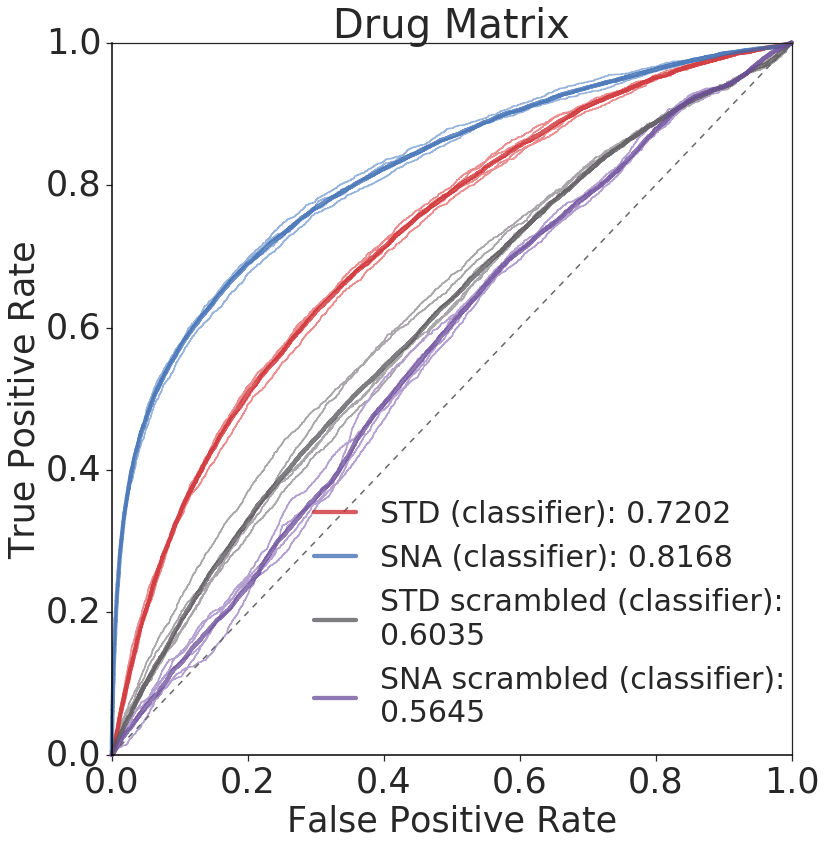

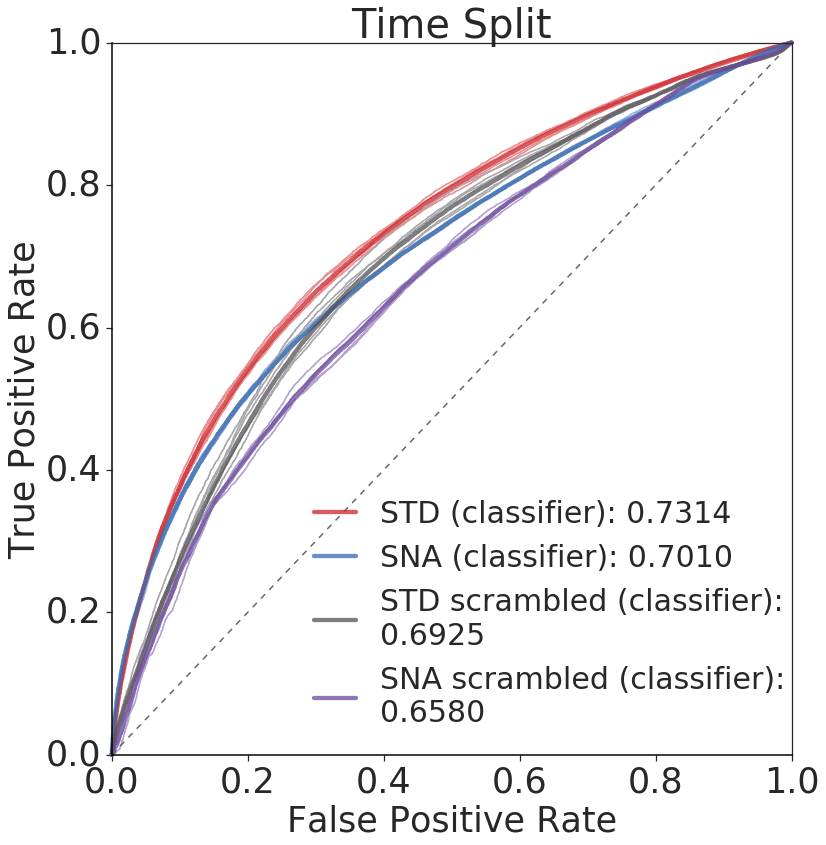

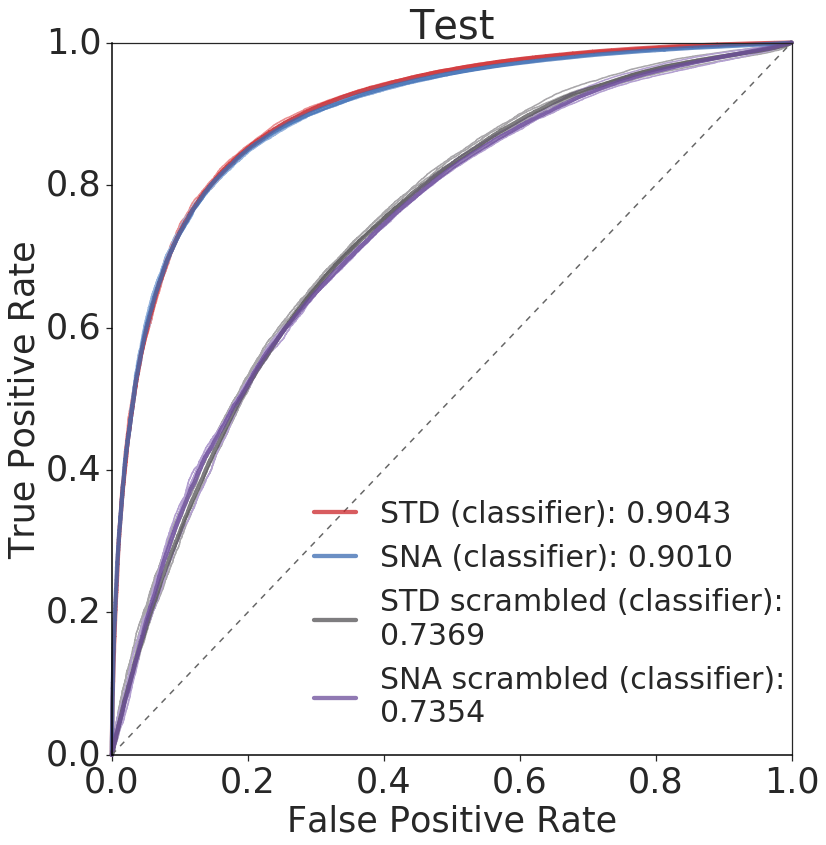

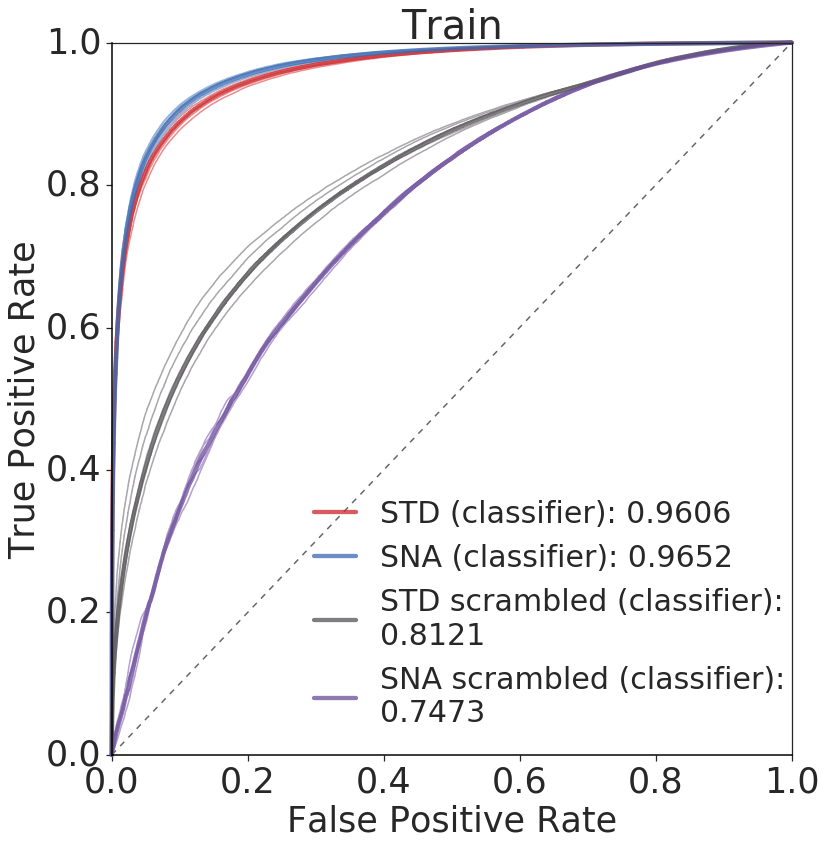

In [29]:
expt_colors = ["STD", "STD_SMA",  "scrambled_idx_no_SMA", "scrambled_idx", ]
expt_order = ['CLASSIFIER_STD',  'CLASSIFIER_SMA_RATIOS','CLASSIFIER_scrambled_idx_No_SMA_LC',
                          'CLASSIFIER_scrambled_idx_LC',]
labels=[expt_legend_lookup[i] for i in expt_order]
plotting_kwargs = {
    "save_name":None,
    "thresh": 5.0,
    "ratio":"1.0",
    "amount":0.5,
    "big_lw":4.3,
    "num_legend_columns":1,
    "legend_bbox":(1.03,0),
    "legend_fontsize":legend_fontsize_all +2,
    "colors" : [color_dict_pt[i] for i in expt_colors],
    "figsize": figsize_all,
    "labelsize" : labelsize_all,
    "titlesize" : titlesize_all,
    "markerfirst" : True,
    "wrap_label_at" : 30,
}


plot_roc_comp(data_dict, expt_order,"drugmatrix", title="Drug Matrix", label_names=labels, 
              save_as="{}/Drugmatrix_STD_SNA_STDsc_SNAsc".format(save_dir), **plotting_kwargs)
plt.show()
plt.clf()
plot_roc_comp(data_dict, expt_order, "timesplit", title="Time Split", label_names=labels, 
              save_as="{}/Timesplit_STD_SNA_STDsc_SNAsc".format(save_dir),**plotting_kwargs)
plt.show()
plt.clf()
plot_roc_comp(data_dict, expt_order, "test", title="Test", label_names=labels, 
              save_as="{}/Test_STD_SNA_STDsc_SNAsc".format(save_dir),**plotting_kwargs)
plt.show()
plt.clf()
plot_roc_comp(data_dict, expt_order, "train", title="Train", label_names=labels, 
              save_as="{}/Train_STD_SNA_STDsc_SNAsc".format(save_dir),**plotting_kwargs)
plt.show()
plt.clf()

## scrambled plots

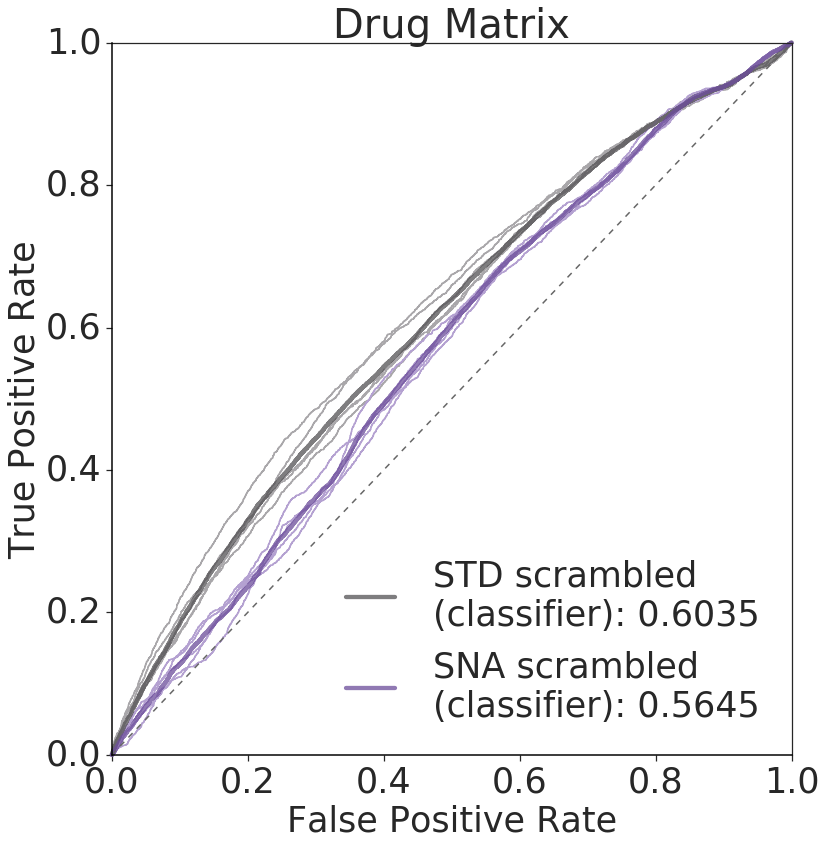

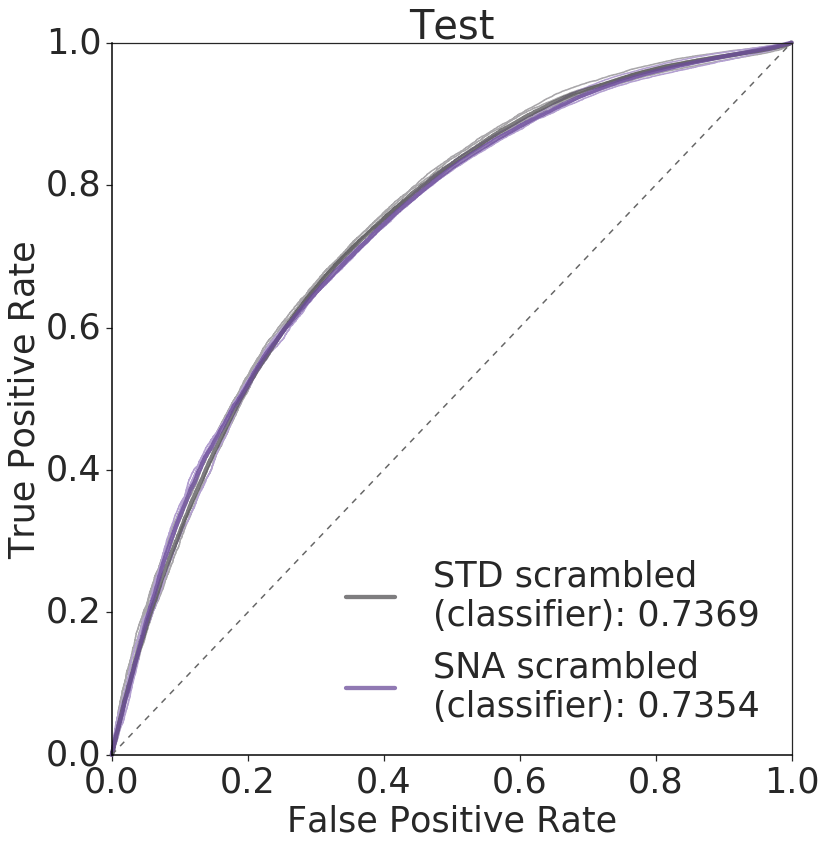

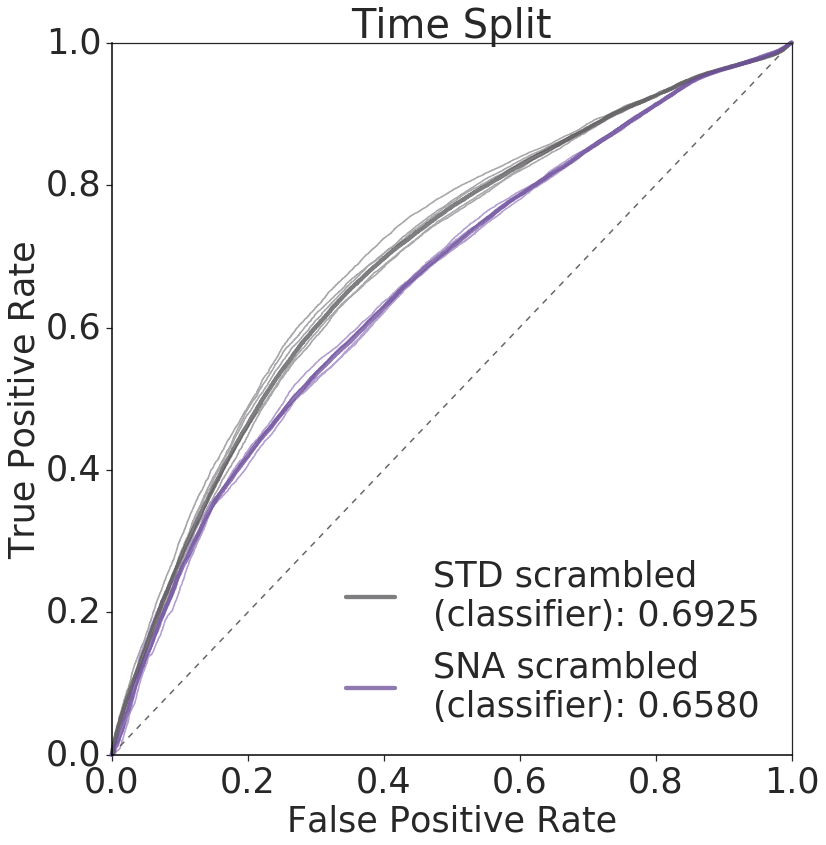

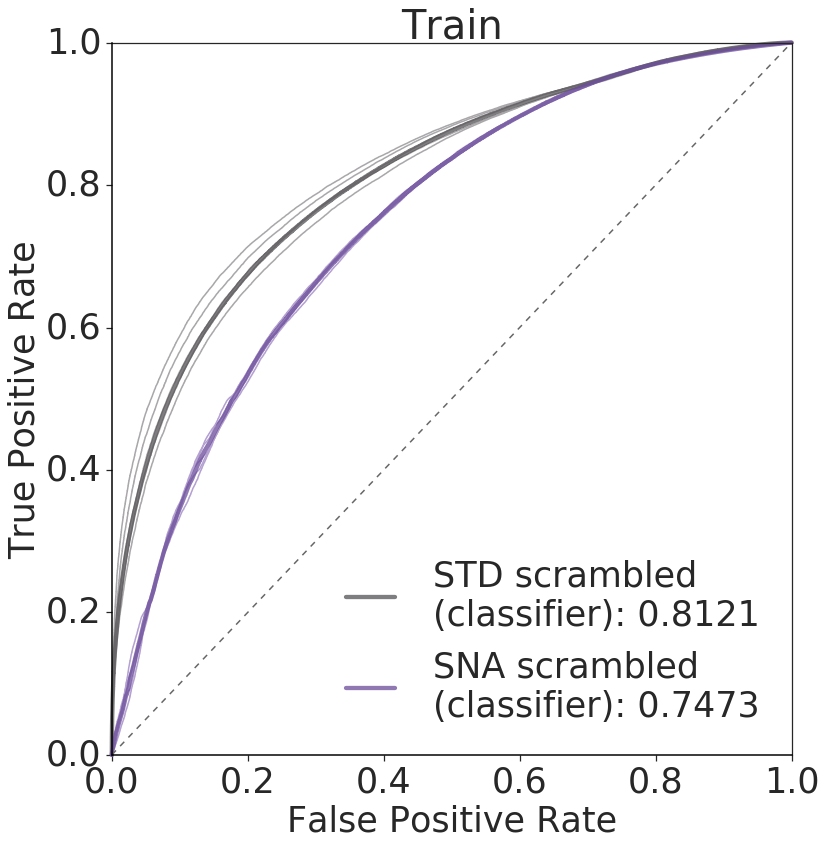

In [41]:
expt_colors = ["scrambled_idx_no_SMA", "scrambled_idx", ]
expt_order = ['CLASSIFIER_scrambled_idx_No_SMA_LC', "CLASSIFIER_scrambled_idx_LC",]

tmp_colors = [color_dict_pt[i] for i in expt_colors]
labels=[expt_legend_lookup[i] for i in expt_order]

plotting_kwargs = {
    "save_name":None,
    "thresh": 5.0,
    "ratio":"1.0",
    "amount":0.5,
    "big_lw":4.3,
    "num_legend_columns":1,
    "legend_bbox":(1,0),
    "legend_fontsize": labelsize_all,
    "colors" : tmp_colors,
    "figsize": figsize_all,
    "labelsize" : labelsize_all,
    "titlesize" : titlesize_all,
    "wrap_label_at" : 20,
}
dsets = ["drugmatrix"]
plot_scrambled_differences(data_dict, expt_order, dsets, title="Drug Matrix",  label_names=labels, 
              save_as="{}/Drugmatrix_STDsc_SNAsc".format(save_dir), **plotting_kwargs)
plt.show()
plt.clf()
dsets = ["test"]
plot_scrambled_differences(data_dict, expt_order, dsets, title="Test", label_names=labels, 
              save_as="{}/Test_STDsc_SNAsc".format(save_dir), **plotting_kwargs)
plt.show()
plt.clf()
dsets = ["timesplit"]
plot_scrambled_differences(data_dict, expt_order, dsets, title="Time Split", label_names=labels, 
              save_as="{}/Timesplit_STDsc_SNAsc".format(save_dir),**plotting_kwargs)
plt.show()
plt.clf()
dsets = ["train"]
plot_scrambled_differences(data_dict, expt_order, dsets, title="Train", label_names=labels, 
              save_as="{}/Train_STDsc_SNAsc".format(save_dir),**plotting_kwargs)
plt.show()
plt.clf()

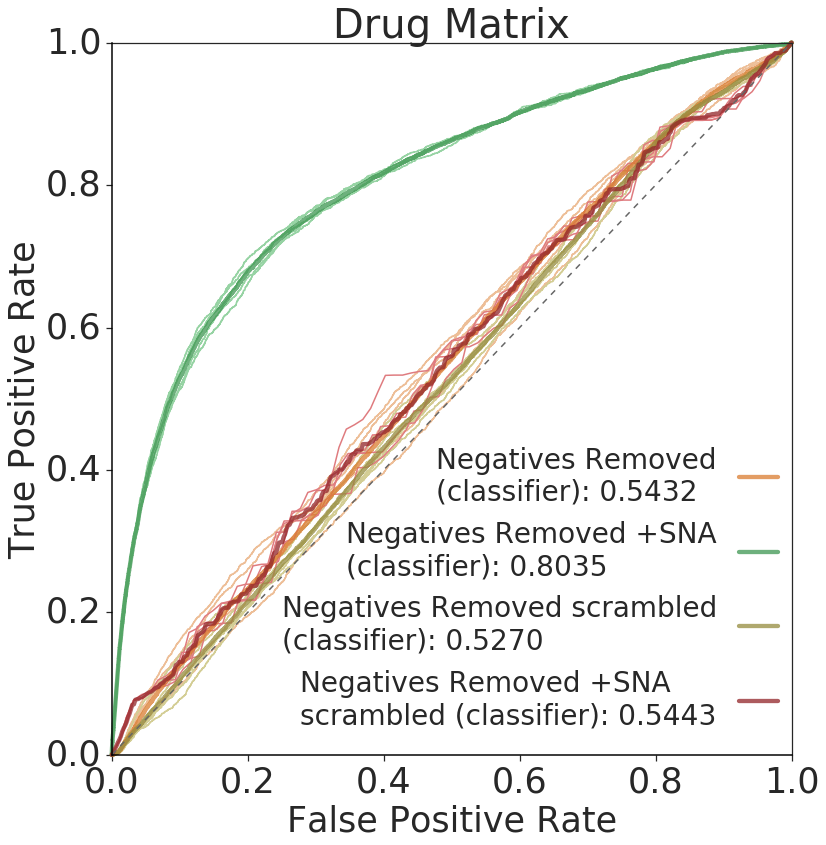

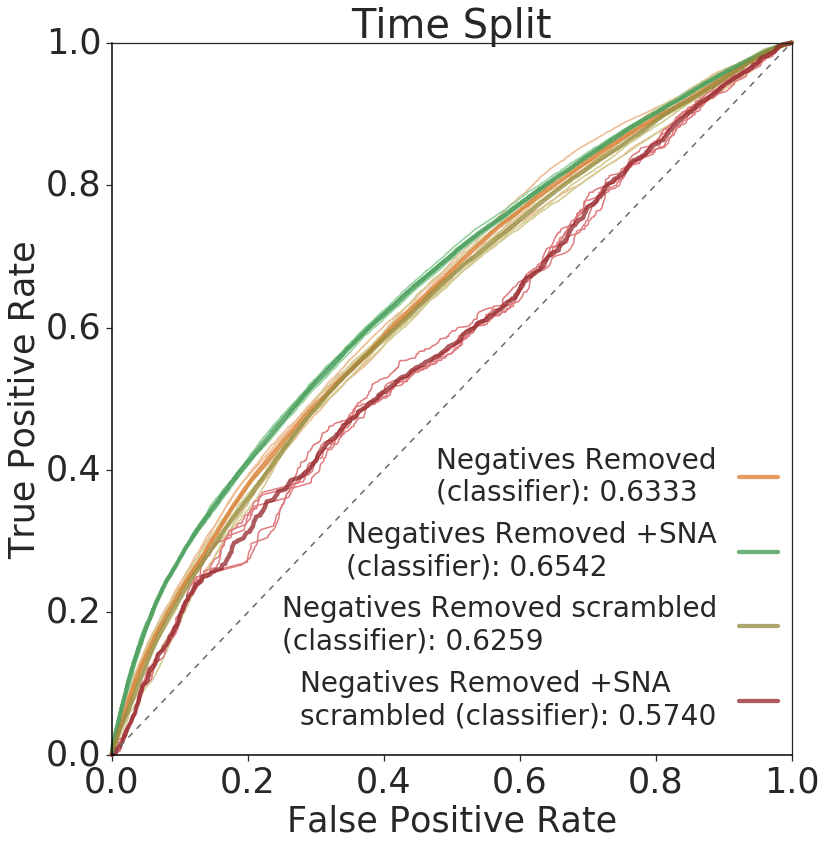

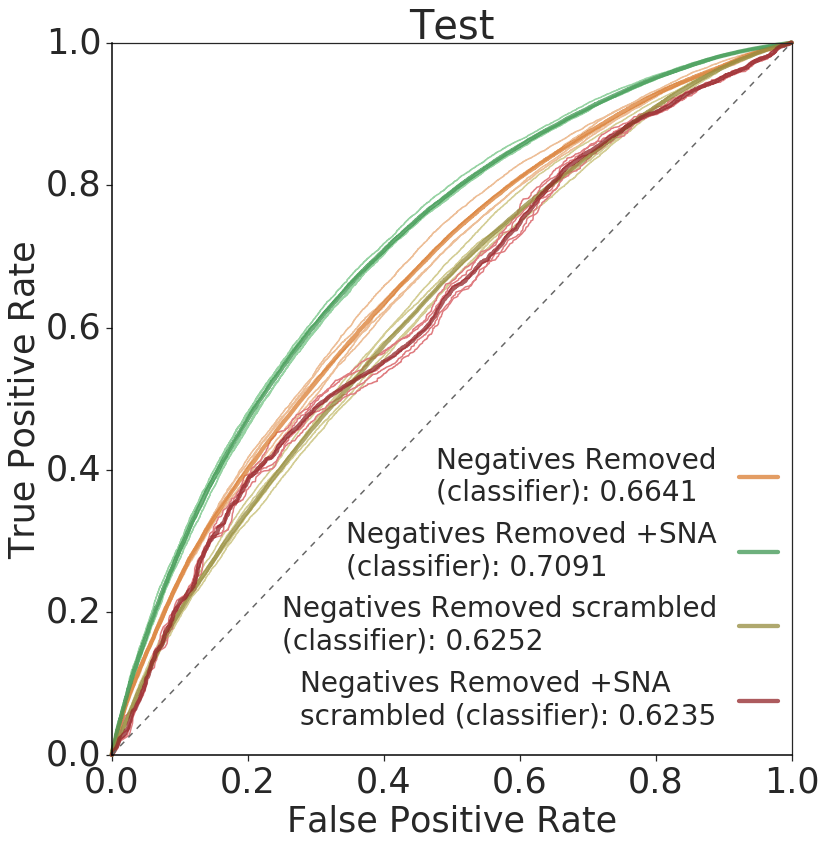

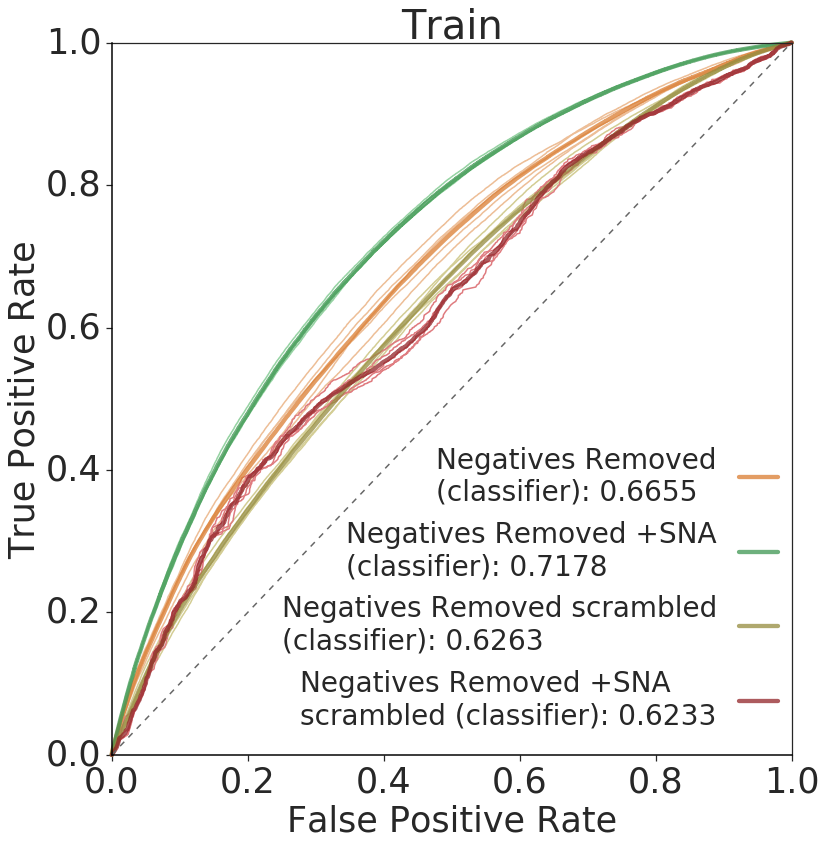

In [40]:
expt_colors = ["NEG_RM", "NEG_RM_SMA",  "SEA_SMA", "NEG_UW", ]
expt_order = ['CLASSIFIER_NEG_RM',  'CLASSIFIER_NEG_RM_SMA_RATIOS','CLASSIFIER_NEG_RM_scrambled',
                          'CLASSIFIER_NEG_RM_RATIOS_scrambled',]
plotting_kwargs = {
    "save_name":None,
    "thresh": 5.0,
    "ratio":"1.0",
    "amount":0.5,
    "big_lw":4.3,
    "num_legend_columns":1,
    "legend_bbox":(1.03, 0),
    "legend_fontsize":legend_fontsize_all,
    "colors" : [color_dict_pt[i] for i in expt_colors],
    "figsize": figsize_all,
    "labelsize" : labelsize_all,
    "titlesize" : titlesize_all,
    "markerfirst" : False,
    "wrap_label_at" : 30,
}
labels=[expt_legend_lookup[i] for i in expt_order]

plot_roc_comp(data_dict, expt_order,
              "drugmatrix", title="Drug Matrix", label_names=labels, save_as="{}/classification_drugmatrix_AUROC_NEGRMs".format(save_dir), **plotting_kwargs)
plt.show()
plt.clf()
plot_roc_comp(data_dict, expt_order, "timesplit", title="Time Split", label_names=labels, save_as="{}/classification_timesplit_AUROC_NEGRMs".format(save_dir), **plotting_kwargs)
plt.show()
plt.clf()
plot_roc_comp(data_dict, expt_order, "test", title="Test", label_names=labels, save_as="{}/classification_test_AUROC_NEGRMs".format(save_dir), **plotting_kwargs)
plt.show()
plt.clf()
plot_roc_comp(data_dict, expt_order, "train", title="Train", label_names=labels, save_as="{}/classification_train_AUROC_NEGRMs".format(save_dir), **plotting_kwargs)
plt.show()
plt.clf()